In [1]:
# Importing the libraries
import datetime
import gc
import glob
import json
import logging
import os
import pickle
import subprocess
import time

import matplotlib
import matplotlib.animation as animation
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import tqdm
from matplotlib import patches
from scipy.stats import boxcox
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from spacepy import pycdf
from torch.utils.data import DataLoader, Dataset, TensorDataset
from torchsummary import summary
from torchvision import models
from torchvision.models.feature_extraction import (create_feature_extractor,
                                                   get_graph_node_names)
from torchvision.transforms.functional import rotate

import utils

In [2]:
os.environ["CDF_LIB"] = "~/CDF/lib"

working_dir = '../../../../data/mike_working_dir/'
region_path = working_dir+'identifying_regions_data/adjusted_regions.pkl'
region_number = '163'
solarwind_path = '../data/SW/omniData.feather'
supermag_dir_path = '../data/supermag/'
twins_times_path = 'outputs/regular_twins_map_dates.feather'
rsd_path = working_dir+'identifying_regions_data/twins_era_stats_dict_radius_regions_min_2.pkl'
RANDOM_SEED = 7
BATCH_SIZE = 16

DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Device: {DEVICE}')

Device: cuda


In [18]:
def loading_data(target_var, region):
	'''
	Function to load the data for the model.

	Args:
		target_var (str): the target variable to be used in the model
		region (int): the region to be used in the model

	Returns:
		pd.DataFrame: the merged dataframe
		float: the mean latitude of the region
		dict: the TWINS maps

	'''

	# loading all the datasets and dictonaries

	regions, stats = utils.loading_dicts()
	solarwind = utils.loading_solarwind(omni=True, limit_to_twins=True)

	# converting the solarwind data to log10
	solarwind['logT'] = np.log10(solarwind['T'])
	solarwind.drop(columns=['T'], inplace=True)

	# reduce the regions dict to be only the ones that have keys in the region_numbers list
	regions = regions[f'region_{region}']
	stats = stats[f'region_{region}']

	# getting dbdt and rsd data for the region
	supermag_df = utils.combining_stations_into_regions(regions['station'], stats, features=['dbht', 'MAGNITUDE', \
		'theta', 'N', 'E', 'sin_theta', 'cos_theta'], mean=True, std=True, maximum=True, median=True)

	# getting the mean latitude for the region and attaching it to the regions dictionary
	mean_lat = utils.getting_mean_lat(regions['station'])

	merged_df = pd.merge(supermag_df, solarwind, left_index=True, right_index=True, how='inner')

	print('Loading TWINS maps....')
	maps = utils.loading_twins_maps()

	return merged_df, mean_lat, maps


def standard_scaling(x, scaling_mean, scaling_std):
	# scaling the data to have a mean of 0 and a standard deviation of 1
	return (x - scaling_mean) / scaling_std


def minmax_scaling(x, scaling_min, scaling_max):
	# scaling the data to be between 0 and 1
	return (x - scaling_min) / (scaling_max - scaling_min)



def getting_prepared_data(get_features=False):
	'''
	Function to get the prepared data for the model.

	Args:
		get_features (bool): whether to return the features of the data

	Returns:
		twins_train (torch.tensor): the training data for the autoencoder
		twins_val (torch.tensor): the validation data for the autoencoder
		twins_test (torch.tensor): the testing data for the autoencoder
		date_dict (dict): the dates of the data
		scaling_mean (float): the mean of the training data
		scaling_std (float): the standard deviation of the training data
		features (list): the features of the data

	'''

	maps = utils.loading_twins_maps()

	# changing all negative values in maps to 0
	for key in maps.keys():
		maps[key]['map'][maps[key]['map'] < 0] = 0

	temp_version = 'pytorch_test'

	with open(working_dir+f'twins_method_storm_extraction_map_keys_version_{temp_version}.pkl', 'rb') as f:
		storms_extracted_dict = pickle.load(f)
	storms = storms_extracted_dict['storms']
	target = storms_extracted_dict['target']
	features = storms[0].columns

	# splitting the data on a day to day basis to reduce data leakage
	day_df = pd.date_range(start=pd.to_datetime('2009-07-01'), end=pd.to_datetime('2017-12-01'), freq='D')
	specific_test_days = pd.date_range(start=pd.to_datetime('2012-03-07'), end=pd.to_datetime('2012-03-13'), freq='D')
	day_df = day_df.drop(specific_test_days)

	train_days, test_days = train_test_split(day_df, test_size=0.1, shuffle=True, random_state=RANDOM_SEED)
	train_days, val_days = train_test_split(train_days, test_size=0.125, shuffle=True, random_state=RANDOM_SEED)

	test_days = test_days.tolist()
	# adding the two dateimte values of interest to the test days df
	test_days = pd.to_datetime(test_days)
	test_days.append(specific_test_days)

	train_dates_df, val_dates_df, test_dates_df = pd.DataFrame({'dates':[]}), pd.DataFrame({'dates':[]}), pd.DataFrame({'dates':[]})
	x_train, x_val, x_test, y_train, y_val, y_test, twins_train, twins_val, twins_test = [], [], [], [], [], [], [], [], []

	# using the days to split the data
	for day in train_days:
		train_dates_df = pd.concat([train_dates_df, pd.DataFrame({'dates':pd.date_range(start=day, end=day+pd.DateOffset(days=1), freq='min')})], axis=0)

	for day in val_days:
		val_dates_df = pd.concat([val_dates_df, pd.DataFrame({'dates':pd.date_range(start=day, end=day+pd.DateOffset(days=1), freq='min')})], axis=0)

	for day in test_days:
		test_dates_df = pd.concat([test_dates_df, pd.DataFrame({'dates':pd.date_range(start=day, end=day+pd.DateOffset(days=1), freq='min')})], axis=0)

	train_dates_df.set_index('dates', inplace=True)
	val_dates_df.set_index('dates', inplace=True)
	test_dates_df.set_index('dates', inplace=True)

	train_dates_df.index = pd.to_datetime(train_dates_df.index)
	val_dates_df.index = pd.to_datetime(val_dates_df.index)
	test_dates_df.index = pd.to_datetime(test_dates_df.index)

	date_dict = {'train':pd.DataFrame(), 'val':pd.DataFrame(), 'test':pd.DataFrame()}

	print(f'Size of the training storms: {len(storms)}')
	print(f'Size of the training target: {len(target)}')
	print(f'Size of the twins maps: {len(maps)}')

	# getting the data corresponding to the dates
	for storm, y, twins_map in zip(storms, target, maps):

		copied_storm = storm.copy()
		copied_storm = copied_storm.reset_index(inplace=False, drop=False).rename(columns={'index':'Date_UTC'})

		if storm.index[0].strftime('%Y-%m-%d %H:%M:%S') in train_dates_df.index:
			x_train.append(storm)
			y_train.append(y)
			twins_train.append(maps[twins_map]['map'])
			date_dict['train'] = pd.concat([date_dict['train'], copied_storm['Date_UTC'][-10:]], axis=0)
		elif storm.index[0].strftime('%Y-%m-%d %H:%M:%S') in val_dates_df.index:
			x_val.append(storm)
			y_val.append(y)
			twins_val.append(maps[twins_map]['map'])
			date_dict['val'] = pd.concat([date_dict['val'], copied_storm['Date_UTC'][-10:]], axis=0)
		elif storm.index[0].strftime('%Y-%m-%d %H:%M:%S') in test_dates_df.index:
			x_test.append(storm)
			y_test.append(y)
			twins_test.append(maps[twins_map]['map'])
			date_dict['test'] = pd.concat([date_dict['test'], copied_storm['Date_UTC'][-10:]], axis=0)

	twins_scaling_array = np.vstack(twins_train).flatten()

	twins_scaling_array = twins_scaling_array[twins_scaling_array > 0]
	scaling_mean = twins_scaling_array.mean()
	scaling_std = twins_scaling_array.std()
	scaling_min = twins_scaling_array.min()
	scaling_max = twins_scaling_array.max()

	# twins_train = [standard_scaling(x, scaling_mean, scaling_std) for x in twins_train]
	# twins_val = [standard_scaling(x, scaling_mean, scaling_std) for x in twins_val]
	# twins_test = [standard_scaling(x, scaling_mean, scaling_std) for x in twins_test]

	# # finding the min values of the training data
	# min_standard_scaling_training_value = np.min([np.min(x) for x in twins_train])

	# # using the min value to shift the data to positive x if it is negative
	# if min_standard_scaling_training_value < 0:
	# 	twins_train = [x - min_standard_scaling_training_value for x in twins_train]
	# 	twins_val = [x - min_standard_scaling_training_value for x in twins_val]
	# 	twins_test = [x - min_standard_scaling_training_value for x in twins_test]


	if not get_features:
		return torch.tensor(twins_train), torch.tensor(twins_val), torch.tensor(twins_test), date_dict, scaling_mean, scaling_std
	else:
		return torch.tensor(twins_train), torch.tensor(twins_val), torch.tensor(twins_test), date_dict, scaling_mean, scaling_std, features



In [4]:
class Autoencoder(nn.Module):
	def __init__(self):
		'''
		Initializing the autoencoder model.

		'''
		super(Autoencoder, self).__init__()
		self.encoder = nn.Sequential(

			nn.Conv2d(in_channels=1, out_channels=64, kernel_size=2, stride=1, padding='same'),
			nn.ReLU(),
			nn.Dropout(0.2),

			nn.Conv2d(in_channels=64, out_channels=128, kernel_size=2, stride=2, padding=0),
			nn.ReLU(),
			nn.Dropout(0.2),

			nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, stride=1, padding='same'),
			nn.ReLU(),
			nn.Dropout(0.2),

			nn.Flatten(),
			nn.Linear(256*45*30, 420),
		)
		self.decoder = nn.Sequential(

			nn.Linear(420, 256*45*30),
			nn.Unflatten(1, (256, 45, 30)),

			nn.ConvTranspose2d(in_channels=256, out_channels=128, kernel_size=3, stride=1, padding=1),
			nn.Dropout(0.2),

			nn.ConvTranspose2d(in_channels=128, out_channels=64, kernel_size=2, stride=2, padding=0),
			nn.Dropout(0.2),

			nn.ConvTranspose2d(in_channels=64, out_channels=32, kernel_size=2, stride=1, padding=1),
			nn.Dropout(0.2),

			nn.ConvTranspose2d(in_channels=32, out_channels=1, kernel_size=2, stride=1, padding=0),
			# nn.ReLU()
		)

	def forward(self, x, get_latent=False):
		'''
		Function to pass the input through the model.

		Args:
			x (torch.tensor): the input data
			get_latent (bool): whether to return the latent space representation of the data

		Returns:
			torch.tensor: the output of the model
		'''

		# x = x.unsqueeze(1)
		latent = self.encoder(x)
		# if get_latent:
		# 	return latent
		# else:
		x = self.decoder(latent)
		return x

In [6]:
def evaluation(model, test, get_layer_outputs=False):
	'''
	Function using the trained models to make predictions with the testing data.

	Args:
		model (object): pre-trained model
		test_dict (dict): dictonary with the testing model inputs and the real data for comparison
		split (int): which split is being tested

	Returns:
		dict: test dict now containing columns in the dataframe with the model predictions for this split
	'''

	# creting an array to store the predictions
	predicted_list, test_list = [], []
	# setting the encoder and decoder into evaluation model
	model.eval()

	# creating a loss value
	running_loss = 0.0

	# making sure the model is on the correct device
	model.to(DEVICE, dtype=torch.float)

	layers = {"encoder.1":"conv1",
			"encoder.4":"conv2",
			"encoder.7":"conv3",
			"encoder.10":"fc1",
			"decoder.0":"fc2",
			"decoder.2":"deconv1",
			"decoder.4":"deconv2",
			"decoder.6":"deconv3",
			"decoder.8":"deconv4"}

	output_lists = {layer:[] for layer in layers.values()}

	with torch.no_grad():
		if isinstance(next(iter(test)), list):
			for X, y in test:
				X = X.to(DEVICE, dtype=torch.float)
				y = y.to(DEVICE, dtype=torch.float)
				X = X.unsqueeze(1)
				predicted = model(X)

				if get_layer_outputs:
					model_layers = create_feature_extractor(model, return_nodes=layers)
					intermediate_layers = model_layers(X)
					for layer in layers.values():
						output_lists[layer].append(intermediate_layers[layer].to('cpu').numpy())

				loss = F.mse_loss(predicted, y)
				running_loss += loss.item()

				# making sure the predicted value is on the cpu
				if predicted.get_device() != -1:
					predicted = predicted.to('cpu')
				if y.get_device() != -1:
					y = y.to('cpu')

				# adding the decoded result to the predicted list after removing the channel dimension
				predicted = torch.squeeze(predicted, dim=1).numpy()
				y = torch.squeeze(y, dim=1).numpy()
				predicted_list.append(predicted)
				test_list.append(y)

		else:
			for test_data in test:
				test_data = test_data.to(DEVICE, dtype=torch.float)

				test_data = test_data.unsqueeze(1)
				predicted = model(test_data)
				loss = F.mse_loss(predicted, test_data)
				running_loss += loss.item()


				if get_layer_outputs:
					model_layers = create_feature_extractor(model, return_nodes=layers)
					intermediate_layers = model_layers(test_data)
					for layer in layers.values():
						output_lists[layer].append(intermediate_layers[layer].to('cpu').numpy())

				# making sure the predicted value is on the cpu
				if predicted.get_device() != -1:
					predicted = predicted.to('cpu')
				if test_data.get_device() != -1:
					test_data = test_data.to('cpu')

				# adding the decoded result to the predicted list after removing the channel dimension
				predicted = torch.squeeze(predicted, dim=1).numpy()
				test_data = torch.squeeze(test_data, dim=1).numpy()
				predicted_list.append(predicted)
				test_list.append(test_data)


	if get_layer_outputs:
		for layer in output_lists.keys():
			output_lists[layer] = np.concatenate(output_lists[layer], axis=0)
		return np.concatenate(predicted_list, axis=0), np.concatenate(test_list, axis=0), running_loss/len(test), output_lists, layers
	else:
		return np.concatenate(predicted_list, axis=0), np.concatenate(test_list, axis=0), running_loss/len(test)


In [19]:
___, ___, test, ___, scaling_mean, scaling_std = getting_prepared_data()

test_input = DataLoader(test, batch_size=1, shuffle=False)

/tmp/ipykernel_2396970/2509228435.py:105: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  train_dates_df = pd.concat([train_dates_df, pd.DataFrame({'dates':pd.date_range(start=day, end=day+pd.DateOffset(days=1), freq='min')})], axis=0)
/tmp/ipykernel_2396970/2509228435.py:108: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  val_dates_df = pd.concat([val_dates_df, pd.DataFrame({'dates':pd.date_range(start=day, end=day+pd.DateOffset(days=1), freq='min')})], axis=0)
/tmp/ipykernel_2396970/2509228435.py

Size of the training storms: 33964
Size of the training target: 33964
Size of the twins maps: 33964


In [5]:
VERSION = 'pytorch_perceptual_v1-35'

model = Autoencoder().to(DEVICE)

try:
	final = torch.load(f'models/autoencoder_{VERSION}.pt')
	model.load_state_dict(final['model'])
except KeyError:
	model.load_state_dict(torch.load(f'models/autoencoder_{VERSION}.pt'))

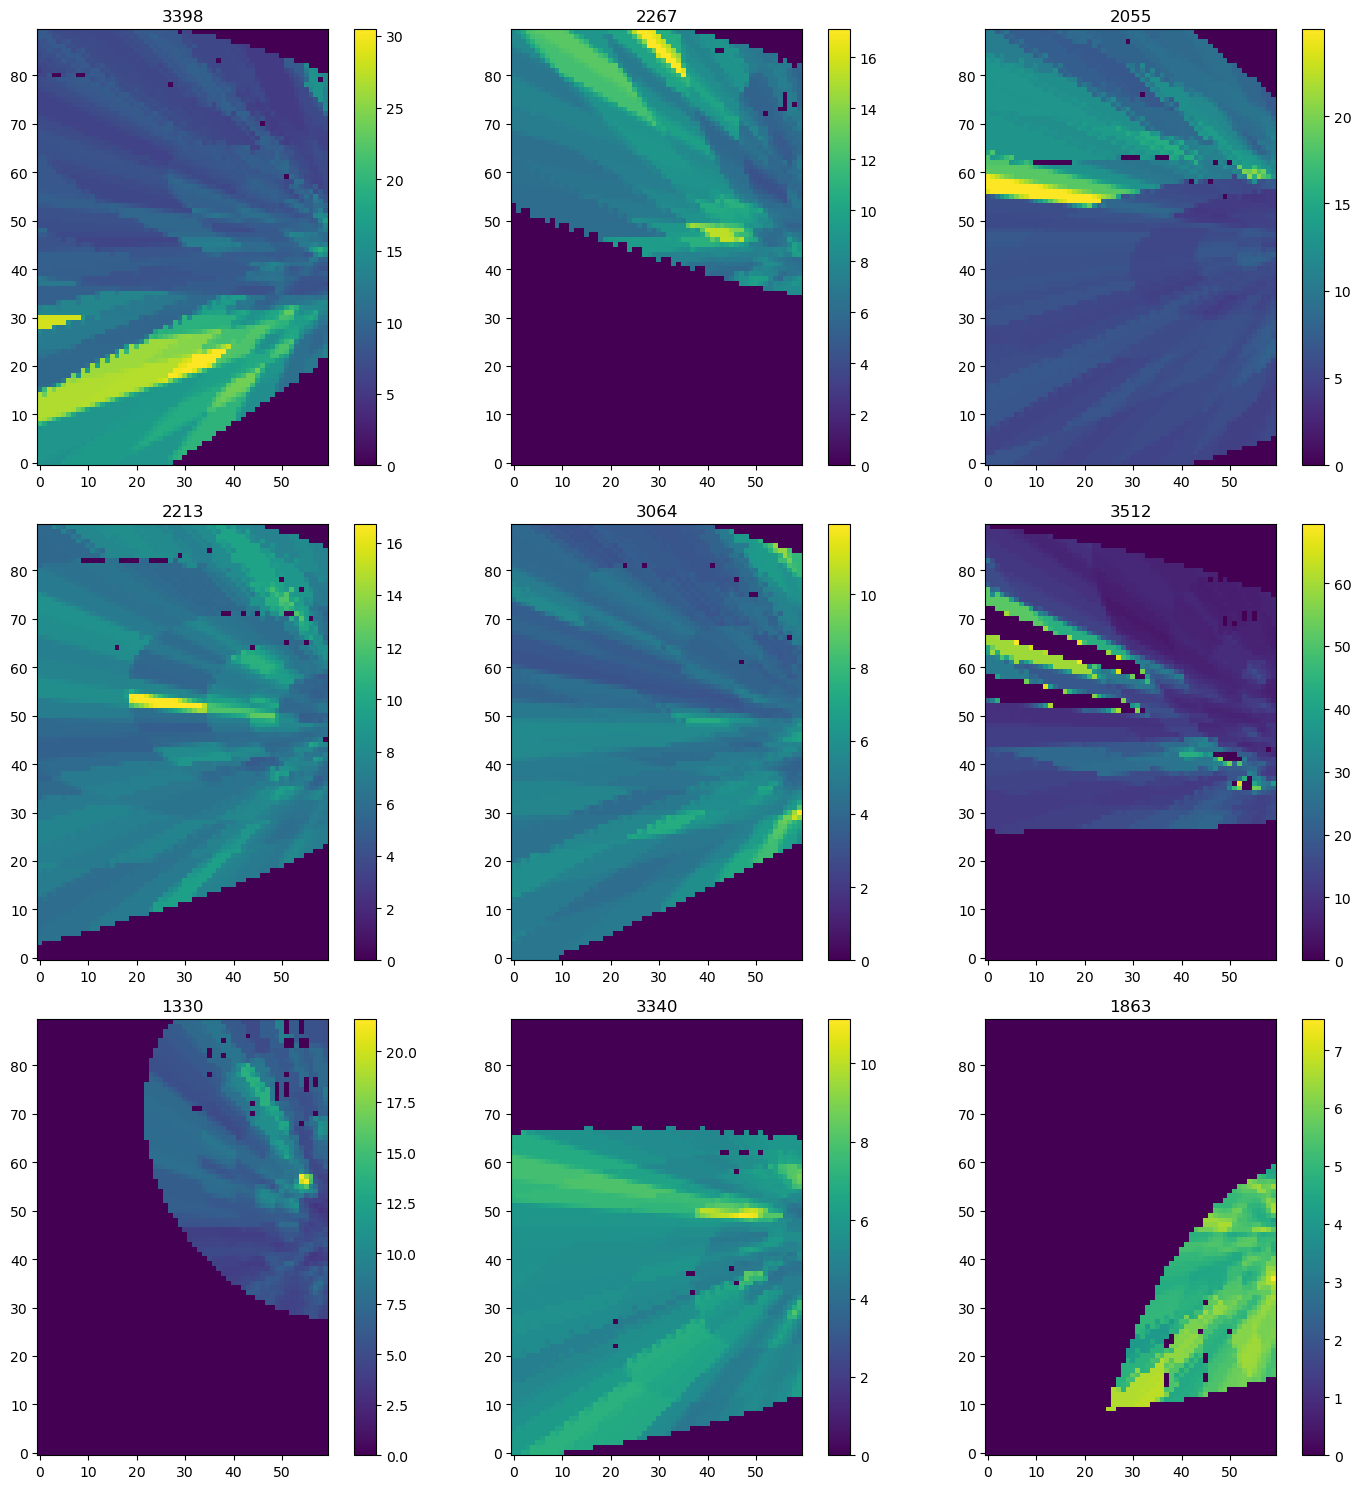

In [62]:
# setting random seed
np.random.seed(40)

# getting a list of 9 random numbers within the index bounds of the test data
rand_ints = np.random.randint(0, len(test), 9)
fig, axes = plt.subplots(3,3, figsize=(15,15))
for i, num  in enumerate(rand_ints):
	# getting the data
	axes[i//3, i%3].imshow(test[num], cmap='viridis', origin='lower')
	axes[i//3, i%3].set_title(num)
	#getting colorbar
	fig.colorbar(axes[i//3, i%3].imshow(test[num], cmap='viridis', origin='lower'), ax=axes[i//3, i%3])
	fig.tight_layout()
plt.show()

### map 2304 is a good example of low temperature mostly empty array for comarison (random seed 3)
### map 174 and 2866 are just interesting looking, almost compelte coverage at low temp (random seed 4)
### map 527 could be good. Has one high temp blob with the rest slightly lower (random seed 10)
### 3331, 2785, 3398 has good percent coverage and high temp blobs (random seed 28, 38, 40)
### 844 is a very bad map (random seed 37)